# Data exploration

## Setting up

In [1]:
# run script that installs missing libraries
! chmod 755 ../scripts.sh
! ./../scripts.sh

  Using cached google_cloud_storage-2.2.1-py2.py3-none-any.whl (107 kB)
  Using cached google_cloud_storage-2.2.0-py2.py3-none-any.whl (107 kB)


### Imports

In [2]:
import os
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [3]:
! ls ../data

ls: cannot access '../data': No such file or directory


In [4]:
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

In [5]:
from google.cloud import storage

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

## Global data:
See that global data has weird time format that needs to be fixed, format is number of months since starting date. Months are counted in 30 days per month, CF format.

In [6]:
#dg = xr.open_dataset('../data/year_ACCESS1-3.nc2', decode_times=False)
globalName = 'ee-downscalingclimatemodels/year_ACCESS1-3.zarr'
dg = xr.open_zarr('gs://'+globalName, decode_times=False)
# rename some variables
dg = dg.rename({'TIME2':'TIME', 'PLEV12_15':'PLEV'})
dg.load()

<xarray.Dataset>
Dimensions:         (LAT: 144, LON: 192, PLEV: 4, bnds: 2, TIME: 151)
Coordinates:
  * LAT             (LAT) float64 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * LON             (LON) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * PLEV            (PLEV) float64 5e+04 6e+04 7e+04 8.5e+04
  * TIME            (TIME) float64 5.5 17.5 29.5 ... 1.794e+03 1.806e+03
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (PLEV, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (TIME, PLEV, LAT, LON) float32 232.7 232.7 ... 267.7 267.7
    TAS             (TIME, LAT, LON) float32 225.6 225.6 225.5 ... 271.3 271.3
    TIME2_bnds      (TIME, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (TIME, PLEV, LAT, LON) float32 0.6384 0.6994 ... -2.163
    VA              (TIME, PLEV, LAT, LON) float32 -1.574 -1.541 ... -0.3436
    ZG              (TIME, PLEV, LAT, LON) float32 4.961e+03 ... 1.368e+03
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1

### Fix time format

In [7]:
# get starting date and units of dataset
units, reference_date = dg.TIME.attrs['units'].split('since')
print('Units: {} and reference date: {} of global dataset'.format(units, reference_date))

# set reference date, add first value in time array
START = datetime(1950,1,15,0,0,0)+timedelta(days=dg.TIME[0].values*30)

print('First date in time array: {}'.format(START))

# Correct the time by having a yearly range from the starting date till 2100
#dg['TIME'] = pd.date_range(start=START, periods=dg.sizes['TIME2'], freq='12M')
# Need to assign new coordinates so that the coordinates of values also change
dg = dg.assign_coords(TIME=pd.date_range(start=START, periods=dg.sizes['TIME'], freq='12M'))
dg.load()

Units: month(360days)  and reference date:  1950-01-15 00:00:00 of global dataset
First date in time array: 1950-06-29 00:00:00


<xarray.Dataset>
Dimensions:         (LAT: 144, LON: 192, PLEV: 4, bnds: 2, TIME: 151)
Coordinates:
  * LAT             (LAT) float64 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * LON             (LON) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * PLEV            (PLEV) float64 5e+04 6e+04 7e+04 8.5e+04
  * TIME            (TIME) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (PLEV, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (TIME, PLEV, LAT, LON) float32 232.7 232.7 ... 267.7 267.7
    TAS             (TIME, LAT, LON) float32 225.6 225.6 225.5 ... 271.3 271.3
    TIME2_bnds      (TIME, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (TIME, PLEV, LAT, LON) float32 0.6384 0.6994 ... -2.163
    VA              (TIME, PLEV, LAT, LON) float32 -1.574 -1.541 ... -0.3436
    ZG              (TIME, PLEV, LAT, LON) float32 4.961e+03 ... 1.368e+03
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1

### Some plots:

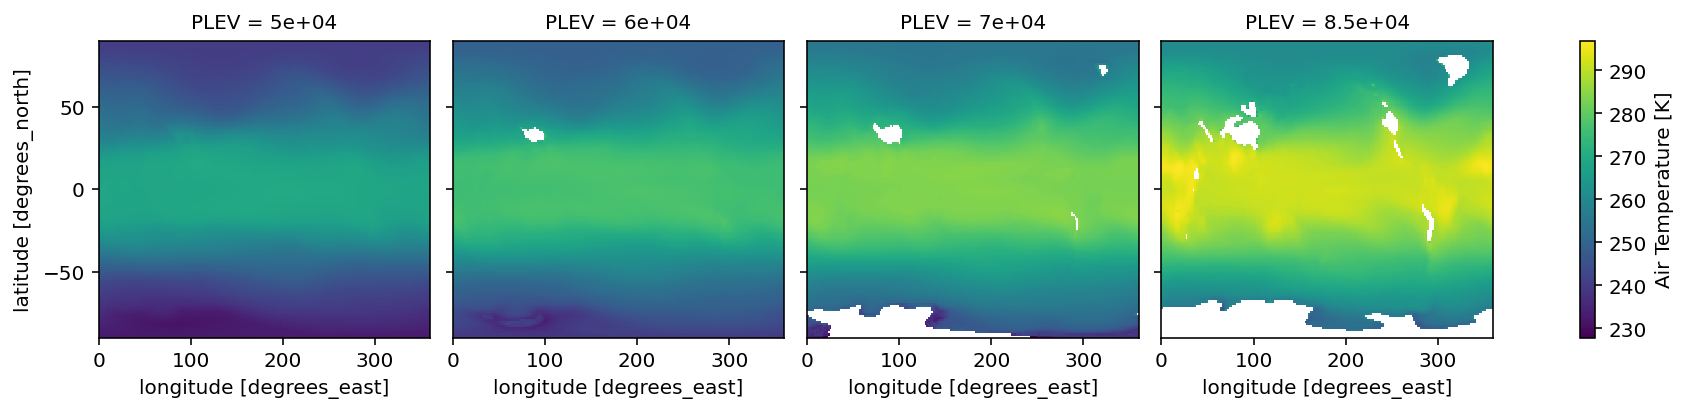

In [8]:
# plot the first timestep and pressure levels
dg.TA.isel(TIME=1).plot(x="LON",col = "PLEV")

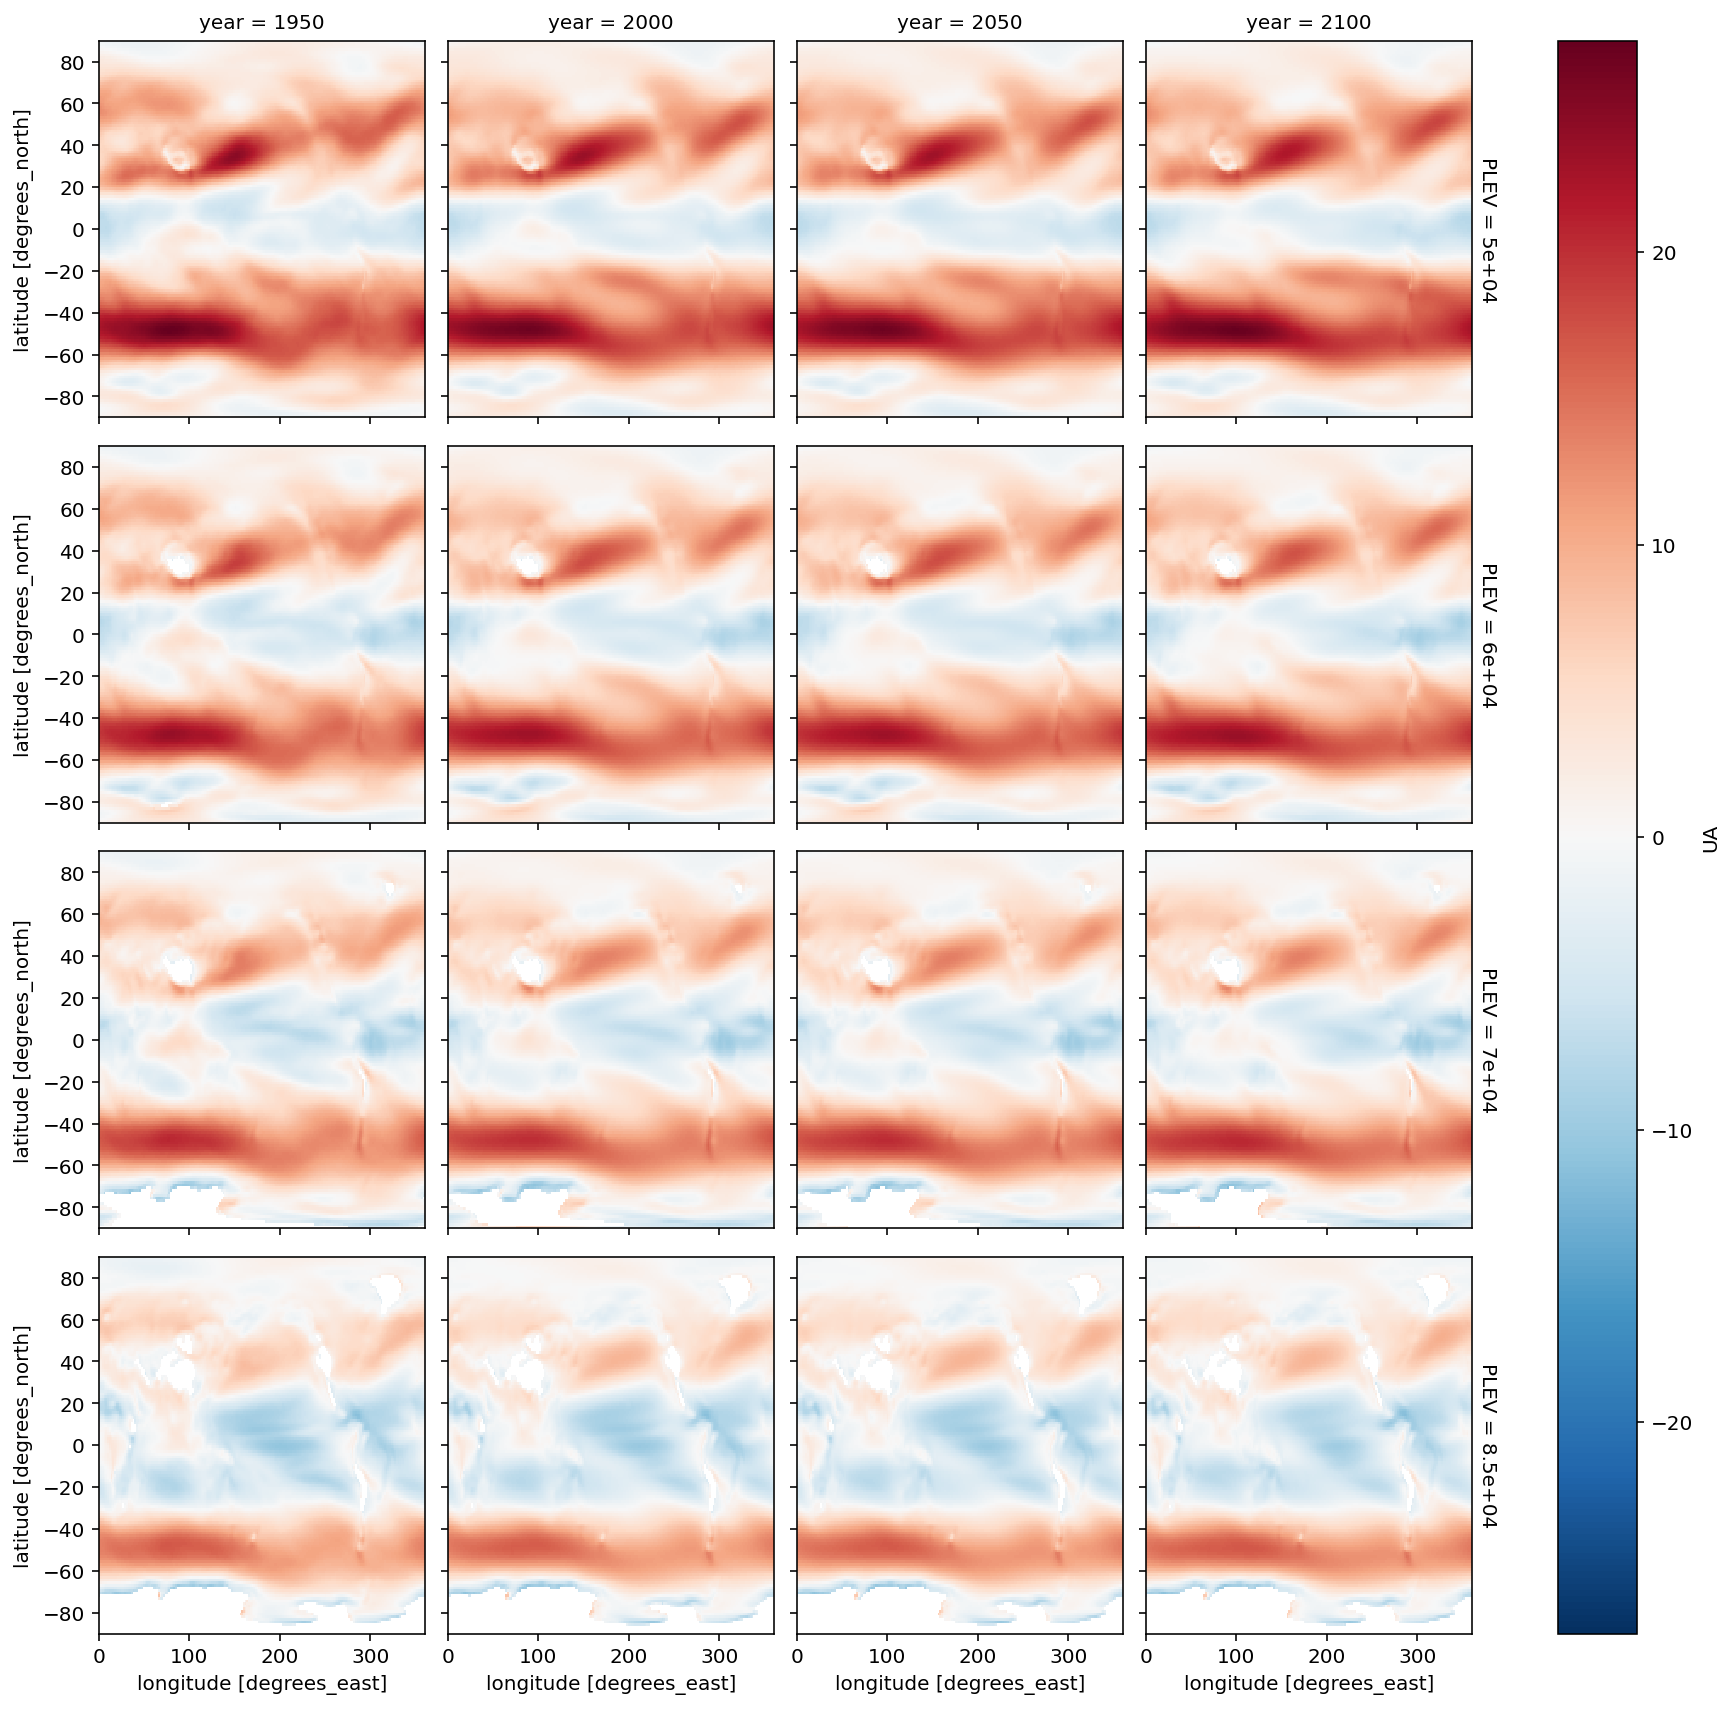

In [9]:
decades = dg.resample(TIME="50Y").mean().groupby("TIME.year").mean()
decades.UA.plot(col="year", row = "PLEV")

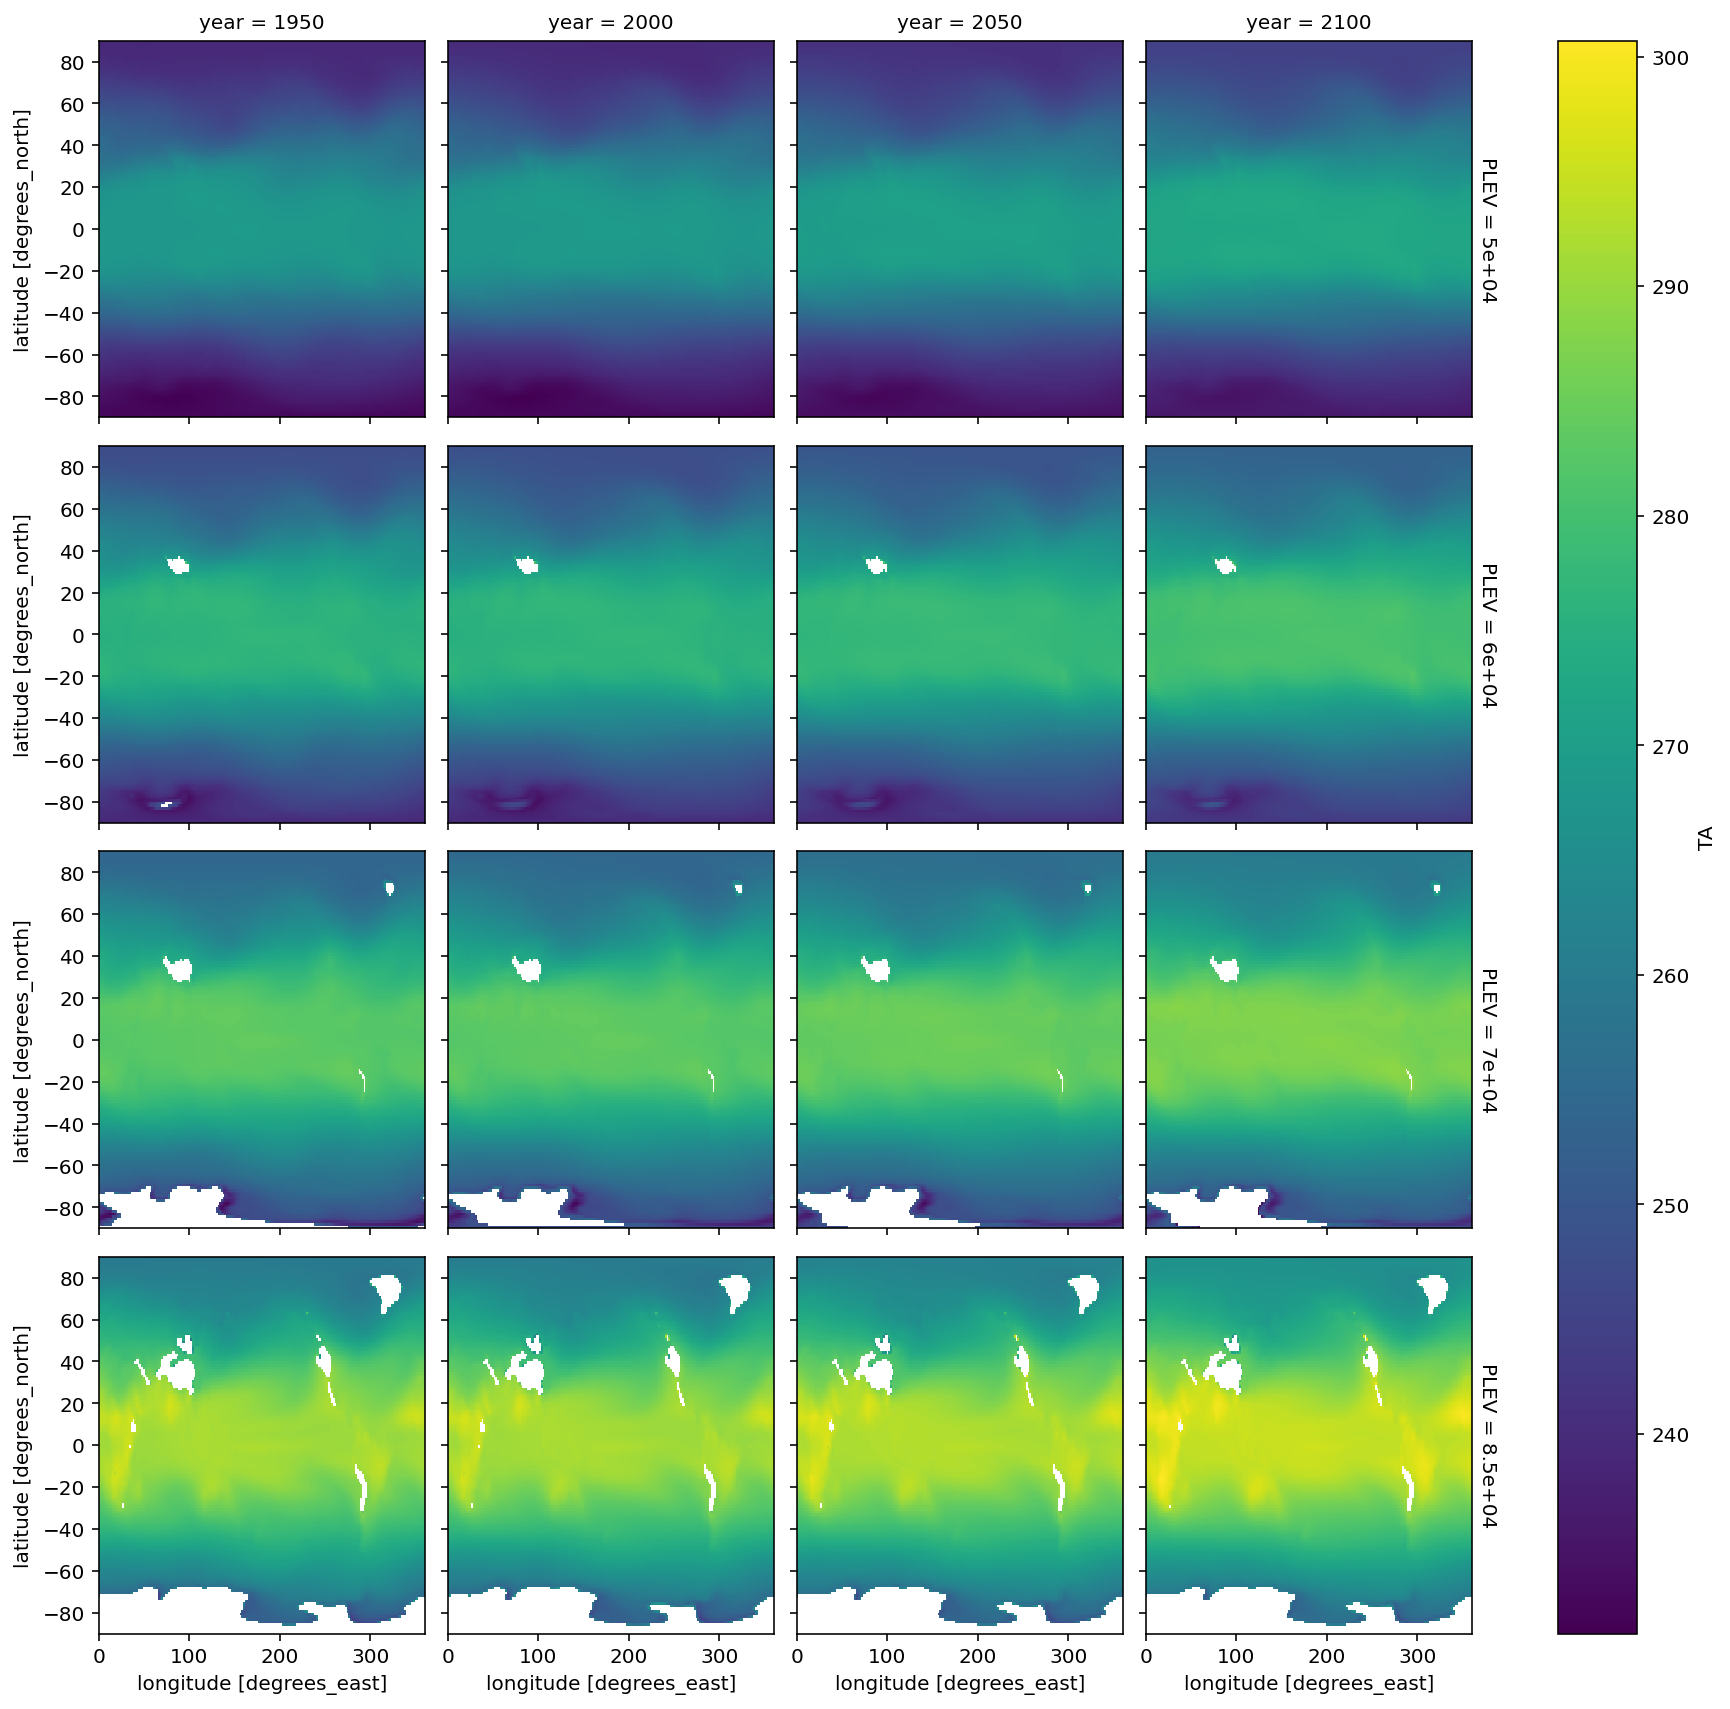

In [10]:
decades.TA.plot(col="year", row = "PLEV")

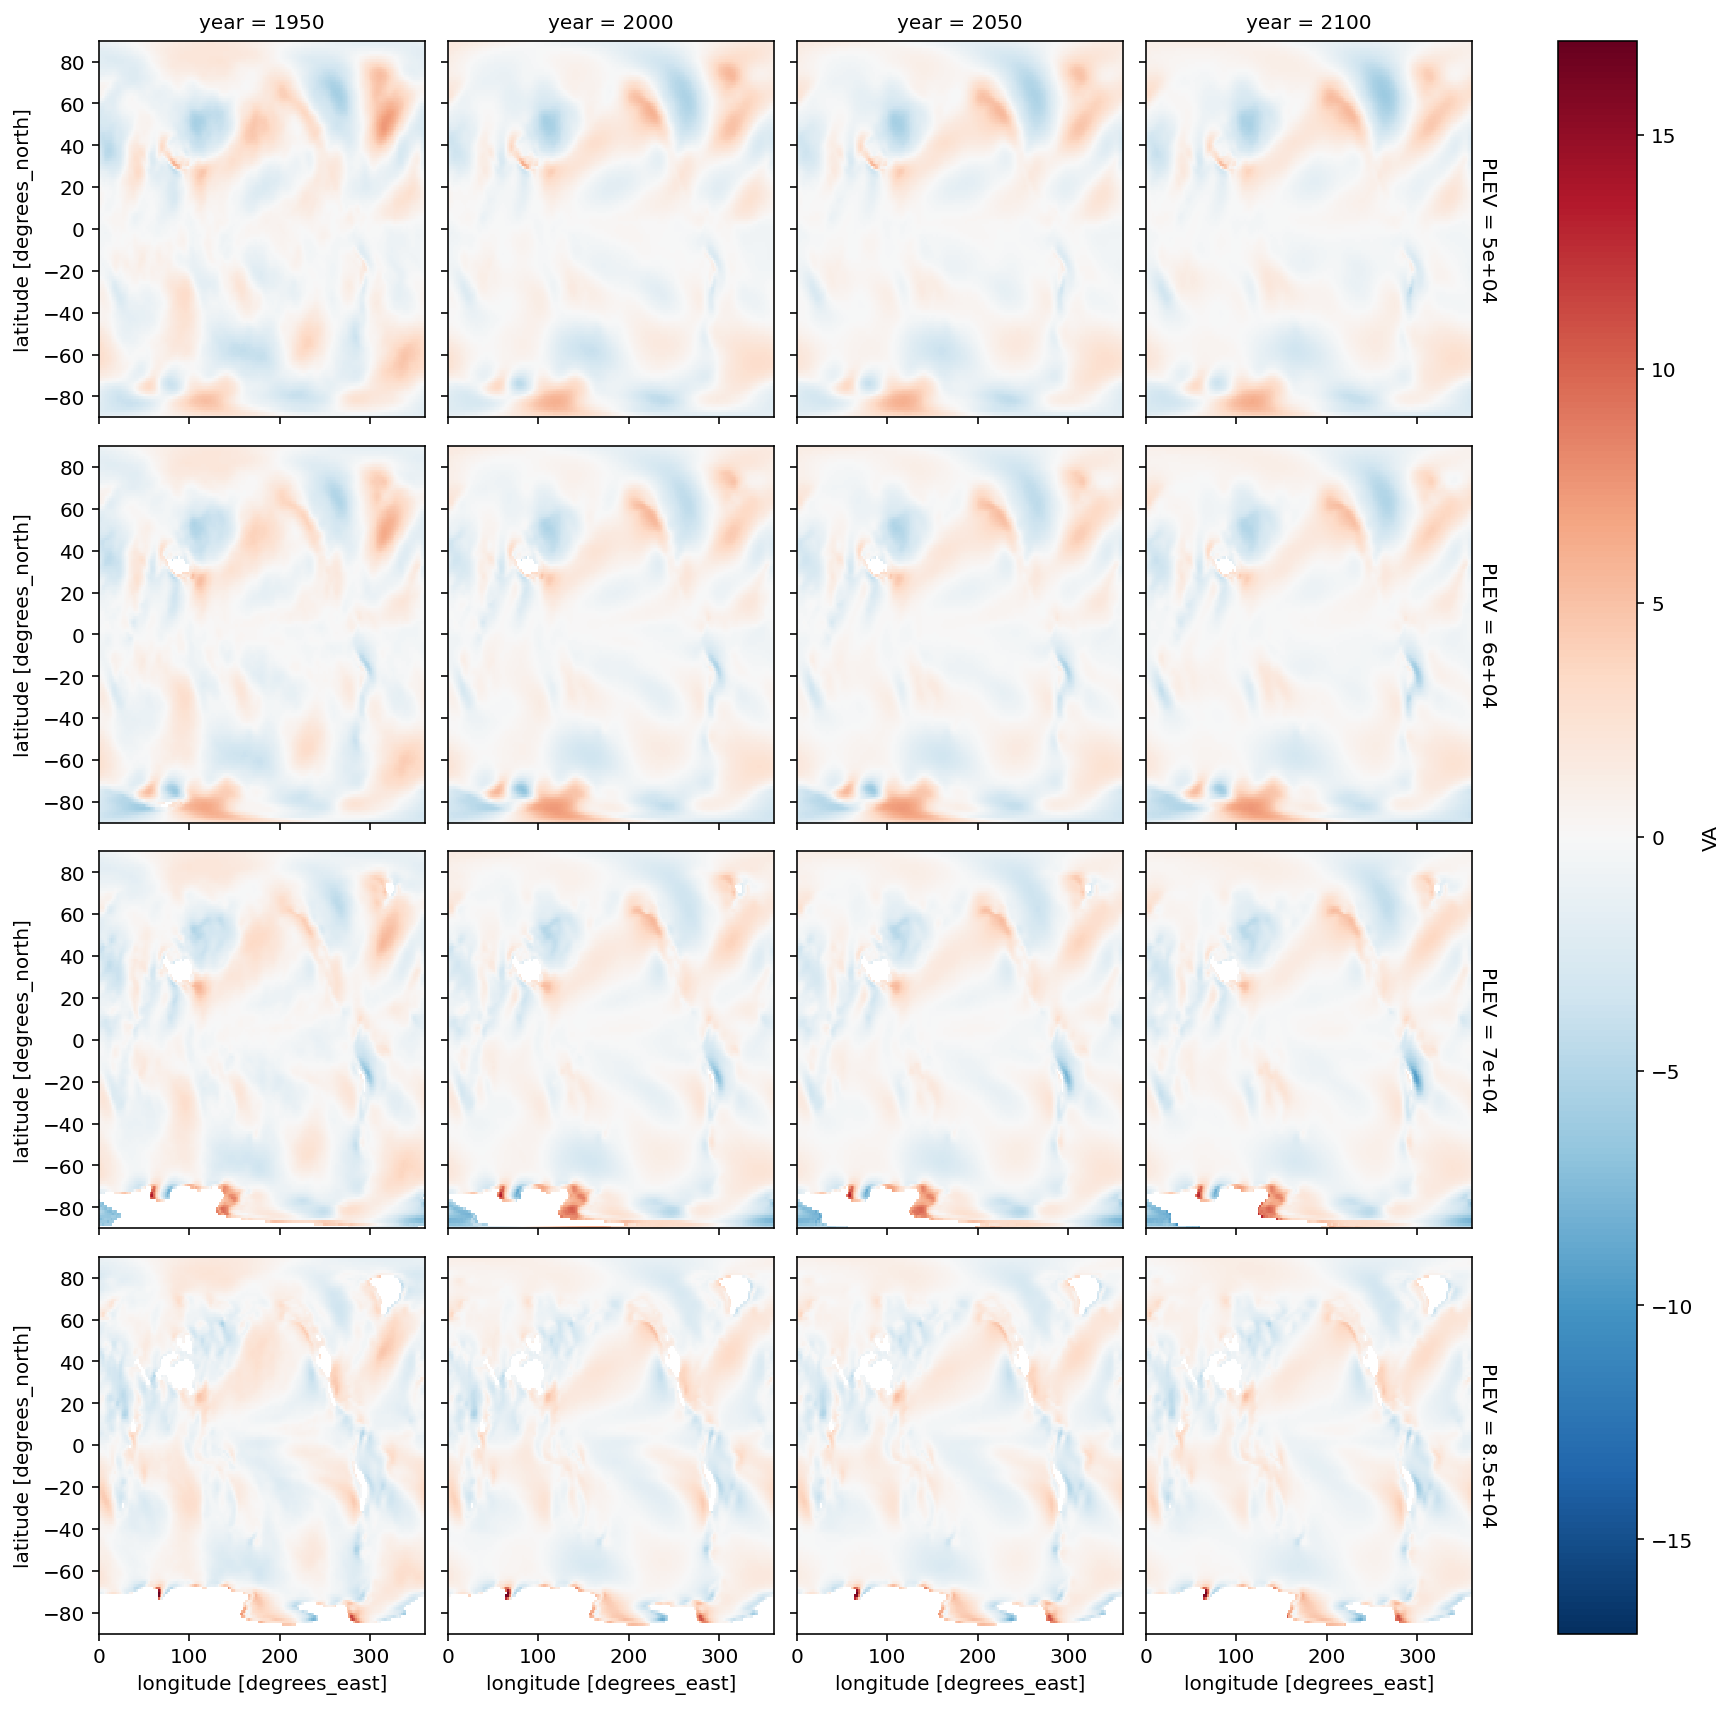

In [11]:
decades.VA.plot(col="year", row = "PLEV")

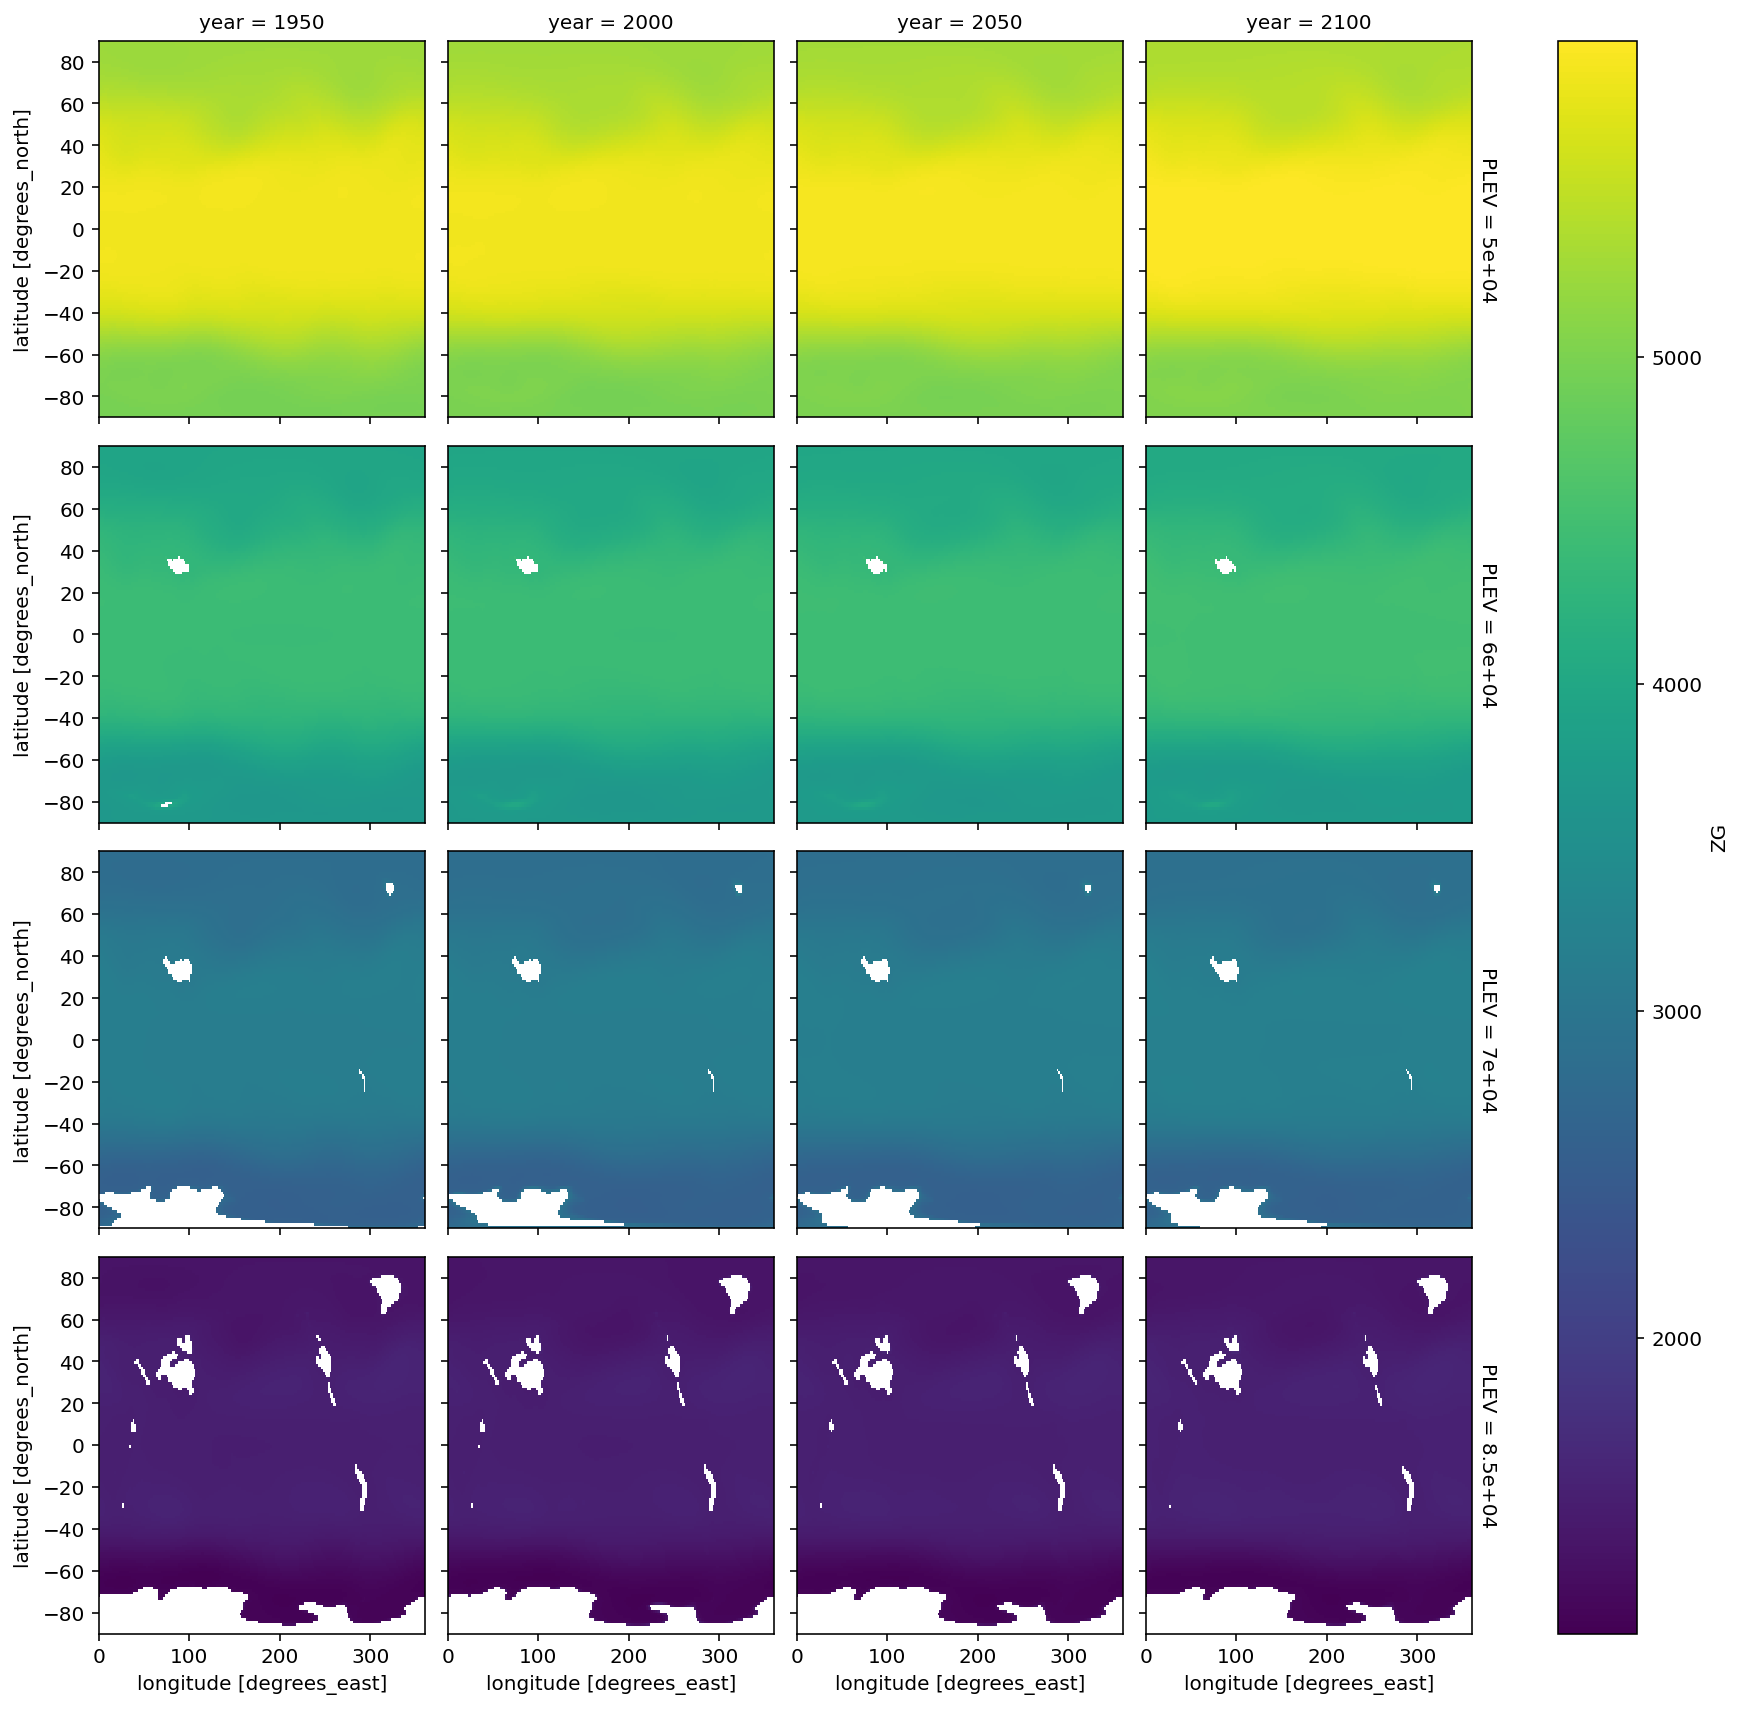

In [12]:
decades.ZG.plot(col="year", row = "PLEV")

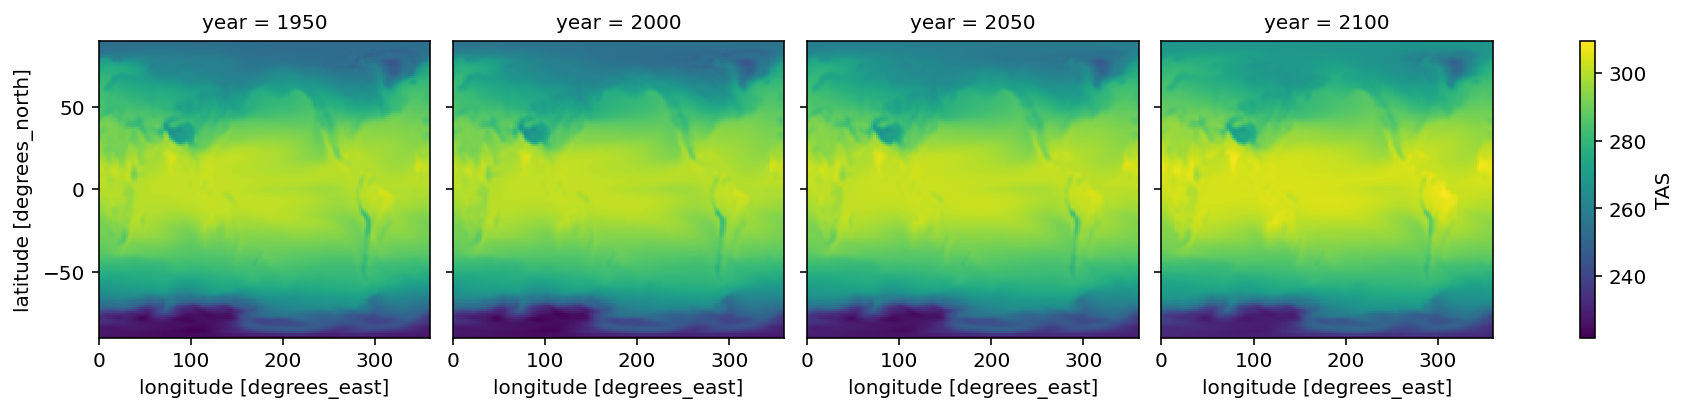

In [13]:
decades.TAS.plot(col="year")

## Regional data:

In [14]:
#dsr = xr.open_dataset('../data/year-MAR_ACCESS1.3-1980-2100_zen.nc2')
localName = 'ee-downscalingclimatemodels/year-MAR_ACCESS1.3-1980-2100_zen.zarr'
dsr = xr.open_zarr('gs://'+localName)
ds = dsr.load()
ds

<xarray.Dataset>
Dimensions:    (TIME: 121, Y: 148, X: 176, SECTOR1_1: 1, bnds: 2)
Coordinates:
  * SECTOR1_1  (SECTOR1_1) float32 1.0
  * TIME       (TIME) datetime64[ns] 1980-07-02 ... 2100-07-02T12:00:00
  * X          (X) float32 -3.01e+03 -2.975e+03 -2.94e+03 ... 3.08e+03 3.115e+03
  * Y          (Y) float32 -2.555e+03 -2.52e+03 ... 2.555e+03 2.59e+03
Dimensions without coordinates: bnds
Data variables:
    RF         (TIME, Y, X) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    RU         (TIME, SECTOR1_1, Y, X) float32 inf inf inf inf ... inf inf inf
    SF         (TIME, Y, X) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SMB        (TIME, SECTOR1_1, Y, X) float64 nan nan nan nan ... nan nan nan
    SU         (TIME, SECTOR1_1, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TIME_bnds  (TIME, bnds) datetime64[ns] 1980-01-01 1981-01-01 ... 2101-01-01
Attributes:
    Conventions:       CF-1.6
    NCO:               netCDF Operators version 4.8.1 (Homepage = http://nco....
    contact:           ckittel@uliege.be
    creation_date:     2021-01-23-T13:24:17Z
    driving_model_id:  ACCESS1.3
    institute_id:      ULg
    institution:       University of Liege - Belgium
    reference:         http://www.climato.be
    tracking_id:       ddbf4239bdd46d1127a1bf5625cf2bc0

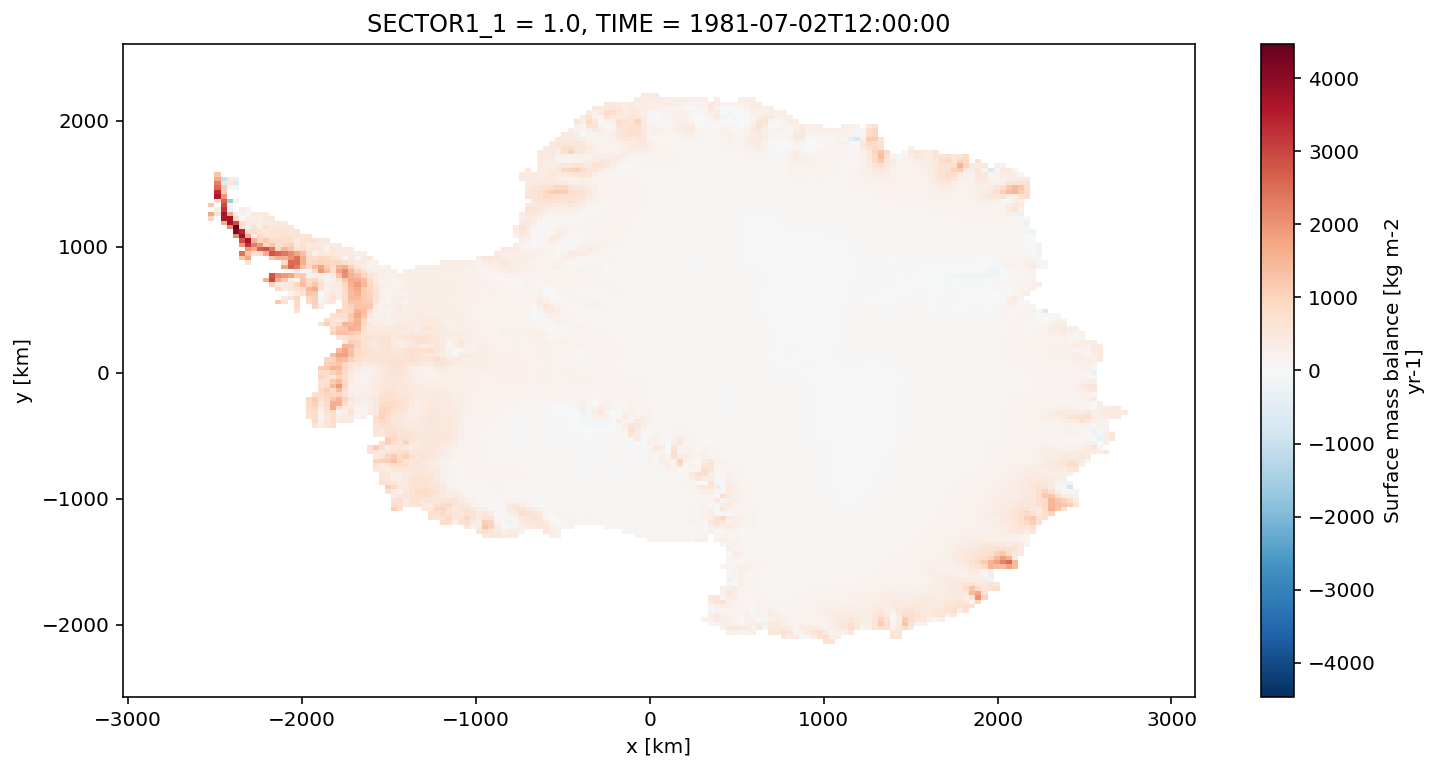

In [15]:
# plot the first timestep
ds.SMB.isel(TIME=1).plot(x="X")

Text(0.5, 1.0, 'Mean SMB values over time')

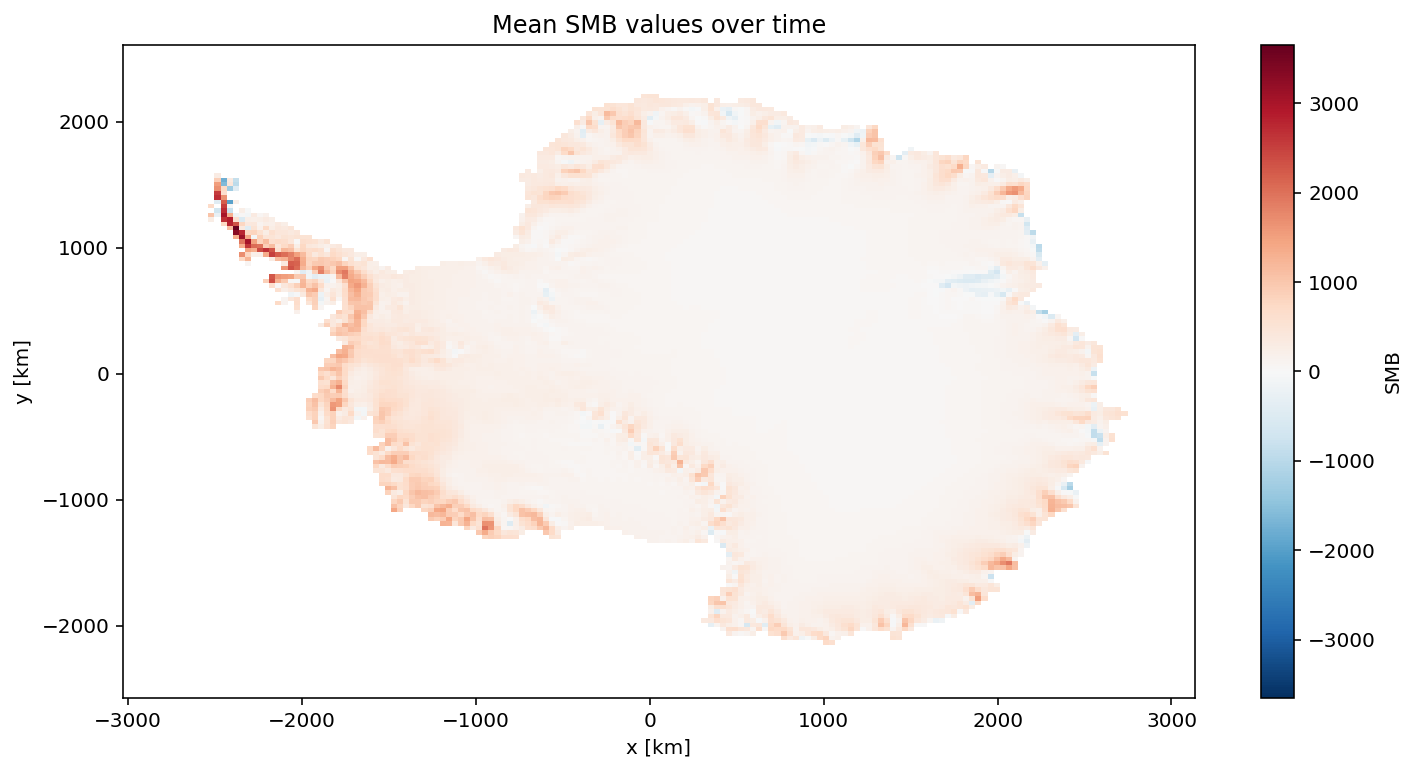

In [16]:
# mean SMB over time
ds.SMB.mean("TIME").plot(x="X")
plt.title('Mean SMB values over time')

Text(0.5, 1.0, 'Mean RF values over time')

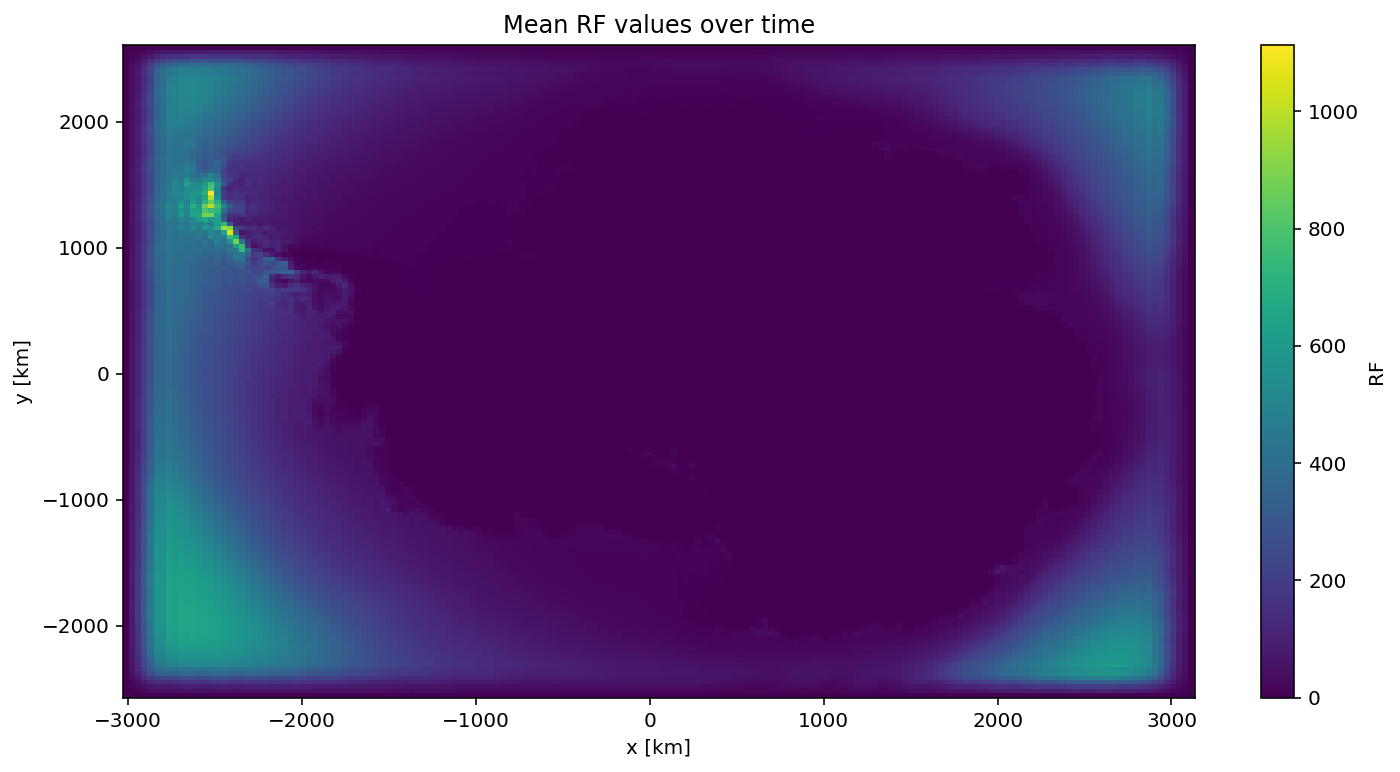

In [17]:
# mean SF over time
ds.RF.mean("TIME").plot(x="X")
plt.title('Mean RF values over time')

Text(0.5, 1.0, 'Mean RU values over time')

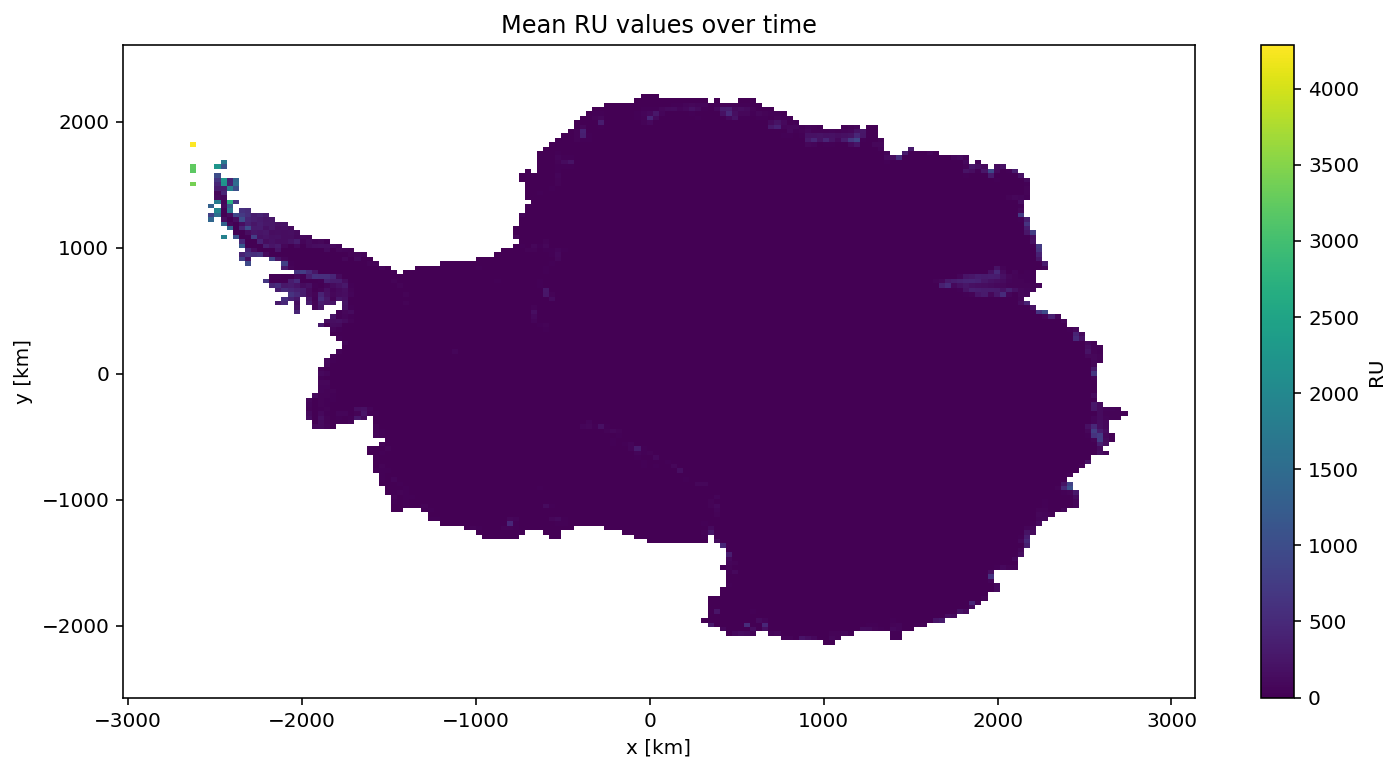

In [18]:
# mean RU over time
ds.RU.mean("TIME").plot(x="X")
plt.title('Mean RU values over time')

Text(0.5, 1.0, 'Mean SU values over time')

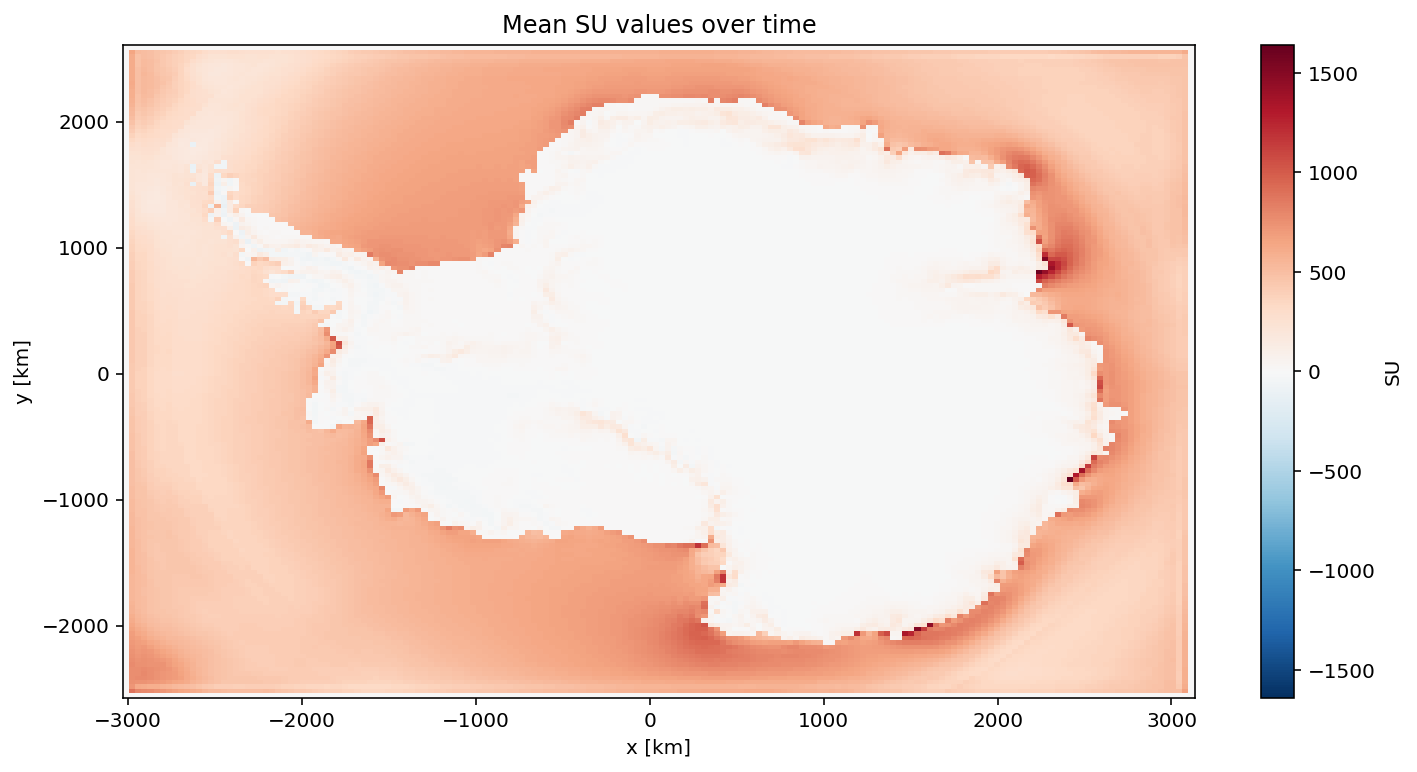

In [19]:
# mean SU over time
ds.SU.mean("TIME").plot(x="X")
plt.title('Mean SU values over time')

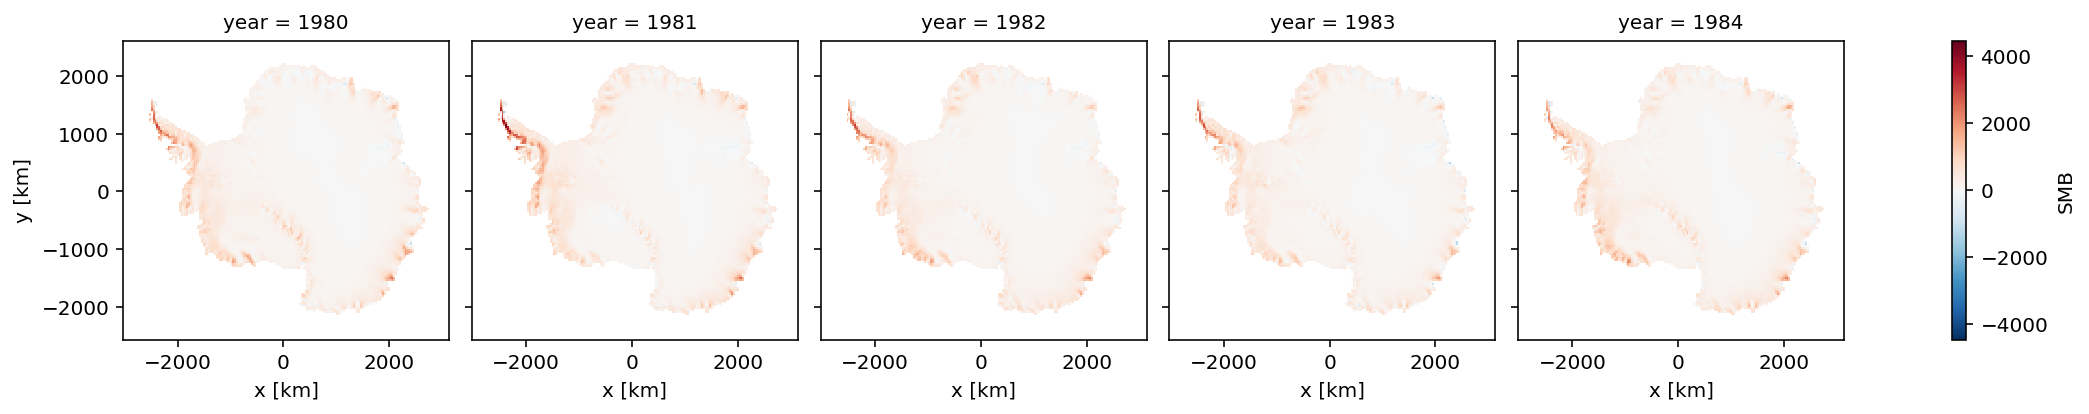

In [20]:
# mean SMB values over first 5 years
yearly_mean = ds.groupby("TIME.year").mean().isel(year=slice(5))
# facet the yearly means
yearly_mean.SMB.plot(col="year")

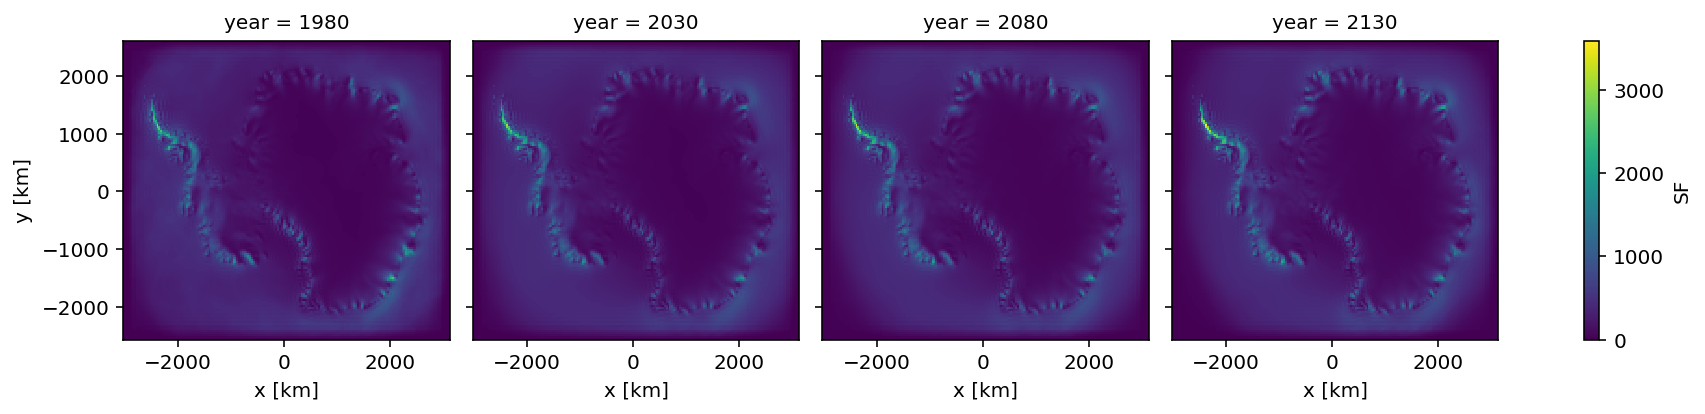

In [21]:
decades = ds.resample(TIME="50Y").mean().groupby("TIME.year").mean()
decades.SF.plot(col="year")

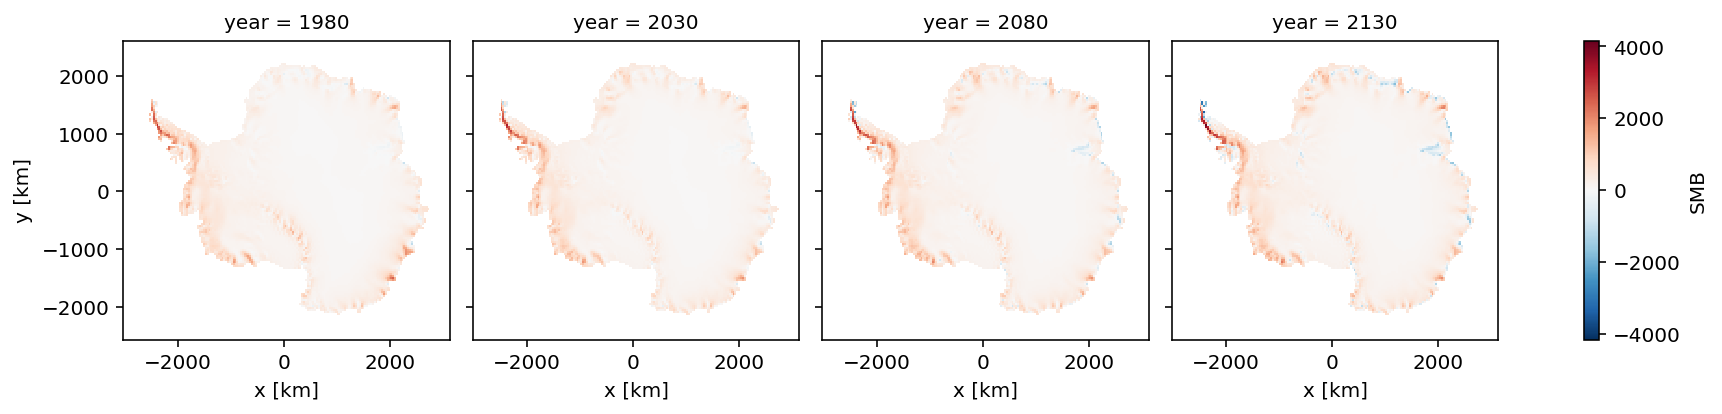

In [22]:
decades.SMB.plot(col="year")

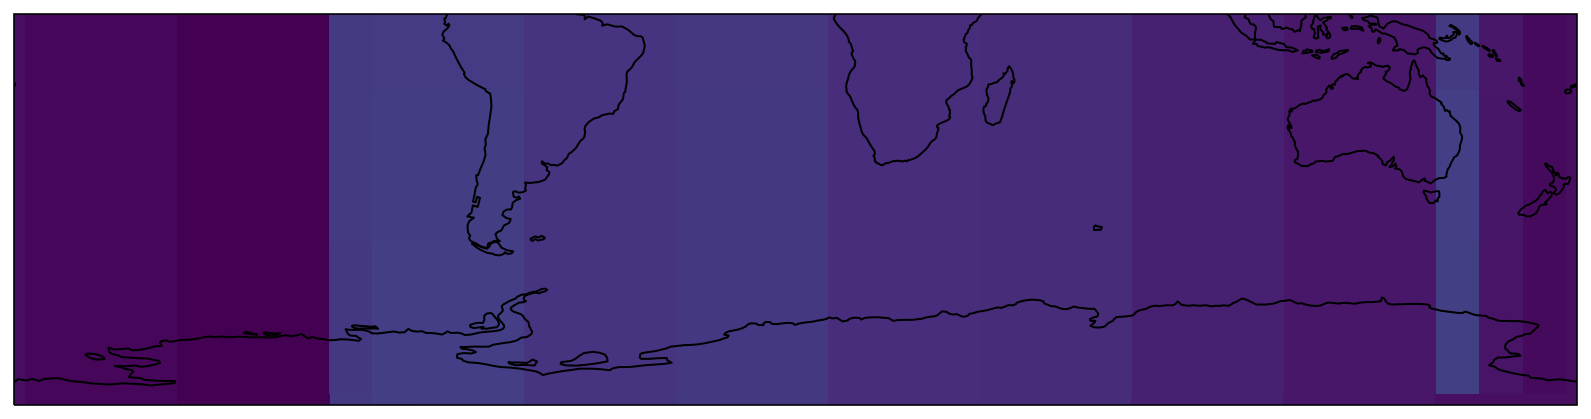

In [23]:
import cartopy.crs as ccrs
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds.SF.mean("TIME").plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="X", y="Y", add_colorbar=False
)
ax.coastlines()
ax.set_ylim([-90, -0]);